In [17]:
pip install pandas numpy scikit-learn openpyxl matplotlib tensorflow


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Input
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import itertools

In [19]:
import os
import random
import numpy as np
import tensorflow as tf

# Set seed for reproducibility
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Optional GPU memory growth config (still valid in TF 2.x)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [20]:
df = pd.read_excel("/Users/fathimabensha/Desktop/DDP_FULL/EDA/FINALDATA.xlsx")

In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Drop NaNs and reset index
df = df.dropna().reset_index(drop=True)

# Separate out features and target
target_column = 'US TBill 10Y Yield(%)'
feature_columns = df.drop(columns=['Date', target_column]).columns

# Define feature and target arrays
features = df[feature_columns]
target = df[target_column].values

# Split index for scaling based only on training data
split_index_raw = int(len(features) * 0.8)

# Fit scaler on training features only
scaler = MinMaxScaler()
scaler.fit(features.iloc[:split_index_raw])

# Scale all features (but not target)
features_scaled = scaler.transform(features)
df_scaled = pd.DataFrame(features_scaled, columns=feature_columns)

# Add the unscaled target back for sequencing
df_scaled[target_column] = target  # keep target unscaled

# Function to create sequences
def create_sequences(data, window, target_idx):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

# Locate target column index in final DataFrame
target_idx = df_scaled.columns.get_loc(target_column)

# Create sequences
history_window = 12
X_all, y_all = create_sequences(df_scaled.values, history_window, target_idx)

# Final train-test split
split_index = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [23]:
param_grid = {
    'units': [32, 64, 128],
    'dropout': [0, 0.1, 0.2],
    'learning_rate': [ 0.01, 0.02, 0.1],
    'batch_size': [32, 64]
}

In [24]:
# Track best model and performance
best_model = None
best_loss = float('inf')
best_params = None
history_dict = {}

In [25]:
for units, dropout, lr, batch_size in itertools.product(
    param_grid['units'],
    param_grid['dropout'],
    param_grid['learning_rate'],
    param_grid['batch_size']
):
    print(f"Training model: units={units}, dropout={dropout}, lr={lr}, batch={batch_size}")

    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mse')

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=batch_size,
        verbose=0,
        callbacks=[es]
    )

    loss = model.evaluate(X_test, y_test, verbose=0)
    if loss < best_loss:
        best_loss = loss
        best_model = model
        best_params = {
            'units': units,
            'dropout': dropout,
            'learning_rate': lr,
            'batch_size': batch_size
        }

print("Best model params:", best_params)

Training model: units=32, dropout=0, lr=0.01, batch=32


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training model: units=32, dropout=0, lr=0.01, batch=64
Training model: units=32, dropout=0, lr=0.02, batch=32
Training model: units=32, dropout=0, lr=0.02, batch=64
Training model: units=32, dropout=0, lr=0.1, batch=32
Training model: units=32, dropout=0, lr=0.1, batch=64
Training model: units=32, dropout=0.1, lr=0.01, batch=32
Training model: units=32, dropout=0.1, lr=0.01, batch=64
Training model: units=32, dropout=0.1, lr=0.02, batch=32
Training model: units=32, dropout=0.1, lr=0.02, batch=64
Training model: units=32, dropout=0.1, lr=0.1, batch=32
Training model: units=32, dropout=0.1, lr=0.1, batch=64
Training model: units=32, dropout=0.2, lr=0.01, batch=32
Training model: units=32, dropout=0.2, lr=0.01, batch=64
Training model: units=32, dropout=0.2, lr=0.02, batch=32
Training model: units=32, dropout=0.2, lr=0.02, batch=64
Training model: units=32, dropout=0.2, lr=0.1, batch=32
Training model: units=32, dropout=0.2, lr=0.1, batch=64
Training model: units=64, dropout=0, lr=0.01, b

In [26]:
y_pred = best_model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


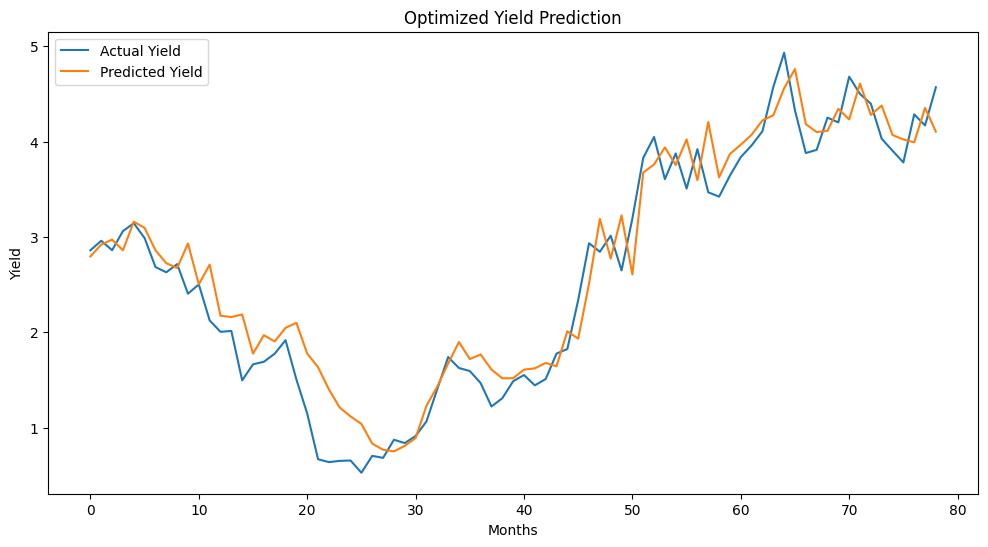

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Yield')
plt.plot(y_pred, label='Predicted Yield')
plt.title("Optimized Yield Prediction")
plt.xlabel("Months")
plt.ylabel("Yield")
plt.legend()
plt.show()

In [28]:
y_train_pred = best_model.predict(X_train)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


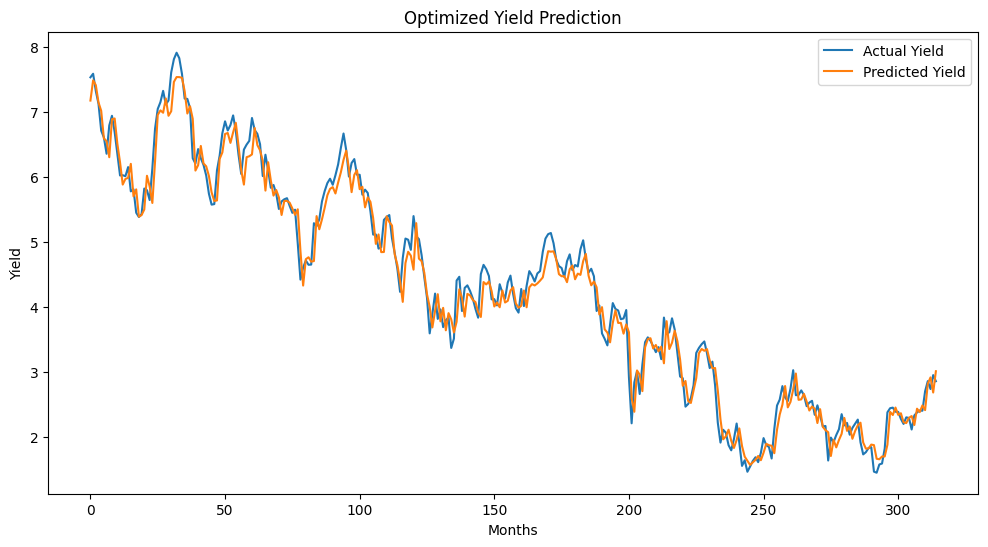

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(y_train, label='Actual Yield')
plt.plot(y_train_pred, label='Predicted Yield')
plt.title("Optimized Yield Prediction")
plt.xlabel("Months")
plt.ylabel("Yield")
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = tf.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"\nTrain RMSE: {rmse_train}")
print(f"Train MSE: {mse_train:.4f}")
print(f"Train MAE: {mae_train:.4f}")
print(f"Train R² Score: {r2_train:.4f}")

mse_test = mean_squared_error(y_test, y_pred)
rmse_test = tf.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse_test}")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test MAE: {mae_test:.4f}")
print(f"Test R² Score: {r2_test:.4f}")


Train RMSE: 0.24658116698265076
Train MSE: 0.0608
Train MAE: 0.1941
Train R² Score: 0.9787

Test RMSE: 0.3340860605239868
Test MSE: 0.1116
Test MAE: 0.2641
Test R² Score: 0.9303
